In [1]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

In [2]:
def mandelbrot(x, y, max_iters):
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

In [3]:
from numba import cuda
mandel_gpu = cuda.jit(device=True)(mandelbrot)

In [4]:
@cuda.jit
def mandelbrot_image(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

Time taken to create Mandelbrot using GPU: 0.6743126070000471 s


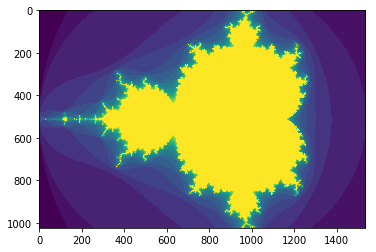

In [5]:
iterations = 20
gimage = np.zeros((1024, 1536), dtype = np.uint8)
grid_dimension = (32,16)
block_dimension = (32, 8)

start = timer()
d_image = cuda.to_device(gimage)
mandelbrot_image[grid_dimension, block_dimension](-2.0, 1.0, -1.0, 1.0, d_image, iterations)
d_image.to_host()
dt = timer() - start

print("Time taken to create Mandelbrot using GPU: {} s".format(dt))

imshow(gimage)
show()